<a href="https://colab.research.google.com/github/cancan-lab/Notebook-DM2/blob/main/DM2_Text_Clustering_Enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTS DM2 — TEXT Clustering (Enhanced)

Peningkatan kualitas pemisahan tema:
- Gunakan **`overview` saja**
- **Stopword domain** (film/movie/story/life/new/man/woman/time/group/series, dll.)
- **N-gram** hingga **bi-gram**
- **TF‑IDF → LSA (TruncatedSVD)**
- **KMeans** (approx. cosine, L2-normalized)
- **UMAP (cosine)** dengan `n_neighbors` lebih besar
- **(Opsional) Sentence Embeddings**
- Ekspor artefak & kata kunci per cluster


## 0) Install & Import

In [1]:
# !pip install umap-learn sentence-transformers -q

import pandas as pd, numpy as np, re, os, json
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
import umap
import matplotlib.pyplot as plt

RNG = np.random.RandomState(42)

## 1) Load CSV (semicolon) & pilih kolom

In [2]:
CSV_PATH = "/content/uts.csv"
df = pd.read_csv(CSV_PATH, sep=";", engine="python")
print(df.shape)
df.head()

(10000, 4)


,id,title,overview,tagline
0,385687,Fast X,Over many missions and against impossible odds...,The end of the road begins.
1,603692,John Wick: Chapter 4,"With the price on his head ever increasing, Jo...","No way back, one way out."
2,502356,The Super Mario Bros. Movie,"While working underground to fix a water main,...",NaN
3,569094,Spider-Man: Across the Spider-Verse,"After reuniting with Gwen Stacy, Brooklyn’s fu...",It's how you wear the mask that matters
4,536437,Hypnotic,A detective becomes entangled in a mystery inv...,Control is an illusion.


## 2) Preprocess — pakai `overview` saja

In [3]:
USE_COL = "overview"
df = df.copy()
df[USE_COL] = df[USE_COL].fillna("")
def clean_text(s):
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+"," ",s)
    s = re.sub(r"[@#]\w+"," ",s)
    s = re.sub(r"\d+"," ",s)
    s = re.sub(r"[^\w\s]"," ",s)
    s = re.sub(r"\s+"," ",s).strip()
    return s
df["text"] = df[USE_COL].astype(str).map(clean_text)
df["len"] = df["text"].str.split().apply(len)
print("Docs:", len(df), "len min/med/max:", int(df.len.min()), int(df.len.median()), int(df.len.max()))
df[["text"]].head(3)

Docs: 10000 len min/med/max: 0 43 190


,text
0,over many missions and against impossible odds...
1,with the price on his head ever increasing joh...
2,while working underground to fix a water main ...


## 3) TF‑IDF + domain stopwords

In [4]:
# Stopwords & filtering otomatis (tanpa daftar manual)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

MAX_FEATS = 60000
MIN_DF    = 5          # buang kata yg sangat jarang (muncul <5 dokumen)
MAX_DF    = 0.70       # buang kata yg terlalu umum (muncul di >70% dokumen)
NGRAM     = (1, 2)

tfidf = TfidfVectorizer(
    max_features=MAX_FEATS,
    min_df=MIN_DF,
    max_df=MAX_DF,
    ngram_range=NGRAM,
    stop_words="english",        # stopwords bawaan (otomatis)
    strip_accents="unicode",
    sublinear_tf=True,           # tf log-scale → kurangi pengaruh kata sangat sering
    token_pattern=r"(?u)\b[a-zA-Z]{2,}\b"  # singkirkan token 1 huruf/angka
)

X = tfidf.fit_transform(df["text"])
X = normalize(X)  # L2, sehingga Euclidean ~ Cosine
print("TF-IDF:", X.shape)


TF-IDF: (10000, 9232)


## 4) LSA / TruncatedSVD

In [5]:
N_COMP = 300
svd = TruncatedSVD(n_components=N_COMP, random_state=42)
X_svd = svd.fit_transform(X)
X_svd = normalize(X_svd)
print("SVD:", X_svd.shape, "| explained variance ≈", round(svd.explained_variance_ratio_.sum(),3))

SVD: (10000, 300) | explained variance ≈ 0.233


## 5) Pilih k terbaik (Silhouette, cosine)

,k,silhouette,calinski,davies
18,20,0.043904,19.655940,5.349495
17,19,0.042694,20.255055,5.282373
16,18,0.041660,20.170643,5.765649
15,17,0.040009,20.644366,5.525682
13,15,0.038444,21.517812,6.168145
14,16,0.037792,21.034219,5.856458
12,14,0.034705,21.627615,5.909313
11,13,0.033187,22.247050,6.092697
10,12,0.032622,22.830656,6.181250
9,11,0.030154,23.167091,6.321530


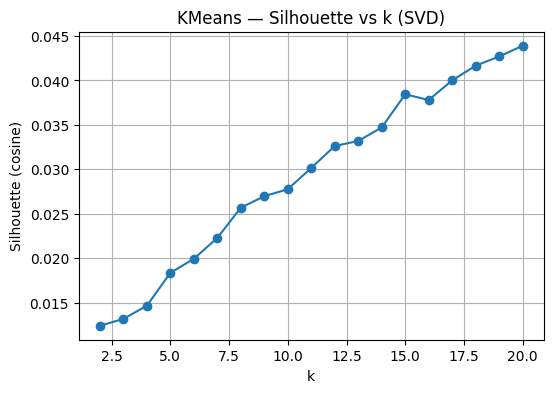

In [6]:
K_MIN, K_MAX, SAMPLE = 2, 20, 4000
idx = np.random.RandomState(42).choice(len(X_svd), size=min(SAMPLE, len(X_svd)), replace=False)
Xs = X_svd[idx]

rows = []; models = {}
for k in range(K_MIN, K_MAX+1):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lab = km.fit_predict(Xs)
    sil = silhouette_score(Xs, lab, metric="cosine")
    ch  = calinski_harabasz_score(Xs, lab)
    db  = davies_bouldin_score(Xs, lab)
    rows.append((k,sil,ch,db))
    models[k] = km

import pandas as pd, matplotlib.pyplot as plt
eval_df = pd.DataFrame(rows, columns=["k","silhouette","calinski","davies"]).sort_values("silhouette", ascending=False)
display(eval_df.head(10))

plt.figure(figsize=(6,4))
plt.plot([r[0] for r in rows], [r[1] for r in rows], marker="o")
plt.grid(True); plt.xlabel("k"); plt.ylabel("Silhouette (cosine)"); plt.title("KMeans — Silhouette vs k (SVD)"); plt.show()

**Interpretasi**

Kurva Silhouette untuk K-Means pada ruang SVD menunjukkan tren naik perlahan dari ~0,012 (k=2) hingga maksimum ~0,044 (k=20). Nilai ini secara absolut sangat kecil, menandakan pemisahan antarkelompok lemah dan tumpang-tindih tinggi. Metrik Calinski–Harabasz tidak menampakkan puncak yang jelas, sedangkan Davies–Bouldin berada di kisaran ~5–6 tanpa penurunan tajam; keduanya menguatkan indikasi bahwa tidak ada struktur klaster yang kuat. Secara numerik, k=20 menjadi ‘terbaik’ versi Silhouette, namun peningkatan tersebut kemungkinan hanya memecah noise menjadi segmen lebih kecil, bukan membentuk topik yang benar-benar terpisah

## 6) Fit akhir (k terbaik)

In [7]:
best_k = int(eval_df.iloc[0]["k"])
print("Best k =", best_k)
km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = km.fit_predict(X_svd)
df["cluster"] = labels

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
sil = silhouette_score(X_svd, labels, metric="cosine")
ch  = calinski_harabasz_score(X_svd, labels)
db  = davies_bouldin_score(X_svd, labels)
print(f"KMeans(SVD, k={best_k}): Silhouette={sil:.4f} | Calinski={ch:.1f} | Davies={db:.3f}")

from sklearn.metrics import pairwise_distances
D = pairwise_distances(X_svd, km.cluster_centers_, metric="cosine")
df["dist"] = D[np.arange(len(D)), labels]

Best k = 20
KMeans(SVD, k=20): Silhouette=0.0468 | Calinski=49.4 | Davies=5.235


**Interpretasi**

Pencarian jumlah klaster memberi k terbaik = 20 dengan metrik: Silhouette = 0,0468, Calinski–Harabasz = 49,4, dan Davies–Bouldin = 5,235. Nilai Silhouette yang sangat kecil serta Davies–Bouldin yang masih tinggi (semakin kecil semakin baik) menunjukkan pemisahan klaster lemah dan tumpang-tindih yang besar; Calinski–Harabasz juga tidak mengindikasikan pemisahan yang tegas. Artinya, meskipun k=20 “terbaik” secara relatif di eksperimen ini, struktur yang terbentuk cenderung memecah noise alih-alih menangkap topik yang benar-benar berbeda.

## 7) Kata kunci per cluster + contoh dokumen

In [8]:
def top_terms_tfidf_by_centroid(X_sparse, labels, vectorizer, topn=12):
    import numpy as np
    k = labels.max()+1
    cent = []
    for c in range(k):
        rows = X_sparse[labels==c]
        cent.append(rows.mean(axis=0) if rows.shape[0] else np.zeros((1, X_sparse.shape[1])))
    cent = np.vstack(cent); cent = np.asarray(cent).reshape(k, -1)
    feats = vectorizer.get_feature_names_out()
    out = []
    for c in range(k):
        idx = np.argsort(-cent[c])[:topn]
        out.append((c, [feats[i] for i in idx]))
    return out

top_terms = top_terms_tfidf_by_centroid(X, labels, tfidf, topn=12)
for c,terms in top_terms:
    print(f"Cluster {c}: {', '.join(terms)}")

examples = {}
for c in sorted(df["cluster"].unique()):
    examples[c] = df[df["cluster"]==c].nsmallest(5, "dist")[["id","title","overview"]]
examples[list(examples.keys())[0]].head()

Cluster 0: los angeles, angeles, los, life, world, young, streets, gang, police, detective, lives, ex
Cluster 1: life, love, new, young, time, live, gets, finds, career, world, lives, love life
Cluster 2: young, friends, group, new, love, time, finds, lives, girl, film, father, wife
Cluster 3: school, high school, high, student, students, teacher, school student, school students, senior, new, girl, life
Cluster 4: town, small, small town, sheriff, mysterious, new, residents, young, life, group, discover, help
Cluster 5: min, jin, hee, soo, yeong, ji, woo, jeong, day, joo, house, sex
Cluster 6: earth, planet, alien, space, world, save, aliens, race, humans, humanity, crew, years
Cluster 7: police, killer, detective, murder, serial, cop, serial killer, officer, case, police officer, investigation, criminal
Cluster 8: son, father, mother, wife, life, young, man, young son, family, years, time, home
Cluster 9: prison, released, released prison, sentence, crime, years, years prison, escape,

,id,title,overview
1291,10634,Friday,Craig and Smokey are two guys in Los Angeles h...
9041,17332,The Soloist,A Los Angeles journalist befriends a homeless ...
3537,417644,CHiPS,The adventures of two California Highway Patro...
6350,1281,Bean,"Childlike Englishman, Mr. Bean, is an incompet..."
7311,14373,Death Wish II,Paul Kersey is again a vigilante trying to fin...


**Interpretasi**

C0 – Los Angeles / kriminal & geng: “los angeles, streets, gang, police, detective” → film berlatar LA bertema geng/kejahatan.

C1 – Drama relasi & karier: “life, love, young, time, career, lives” → kata sangat umum; klaster kurang spesifik.

C2 – Persahabatan remaja: “young, friends, group, love, girl, father, wife”.

C3 – Sekolah menengah: “school, high school, students, senior”.

C4 – Kota kecil & misteri: “small town, sheriff, residents, mysterious”.

C5 – Nama Korea & rumah tangga: dominasi token nama (“min, jin, hee, soo, jeong… house”), indikasi sub-korpus K-drama.

C6 – Fiksi ilmiah luar angkasa: “earth, planet, alien, space, save, aliens”.

C7 – Polisi/detektif/kriminal: “police, detective, serial killer, cop, case, investigation”.

C8 – Relasi keluarga inti: “son, father, mother, family, home”.

C9 – Penjara & kejahatan: “prison, released, sentence, escape, warden”.

C10 – Kerajaan & fantasi: “world, evil, king, battle, princess, kingdom”.

C11 – Sejarah abad (‘th century’): token waktu sejarah/period drama.

C12 – Umur & keluarga: “year old, family, daughter, mother” (masih generik).

C13 – Rumah/keluarga: beririsan kuat dengan C8/C12 → indikasi overlap.

C14 – Kisah berbasis fakta: “story, true story, based on true events”.

C15 – New York: “york, new york, city, young”.

C16 – Tokoh perempuan & relasi: “woman, young woman, husband, relationship”.

C17 – Tokoh laki-laki & konflik pribadi: “man, young man, mother, death”.

C18 – Agen & misi rahasia: “team, agent, mission, fbi, cia, rescue, terrorist”.

C19 – Perang (WWII/civil war): “war, world war, german, soldiers”.

Klasterisasi k=20 hanya menangkap tema-tema besar yang longgar—mis. kriminal/LA, sekolah, kota kecil misteri, sci-fi/alien, polisi–detektif, penjara, kerajaan/fantasi, periode sejarah, New York, agen/misi rahasia, dan perang—serta satu sub-korpus K-drama (nama-nama Korea). Namun banyak klaster masih didominasi kata sangat umum (life, young, new, world) dan tema keluarga/relasi yang berulang di beberapa klaster, menandakan tumpang-tindih tinggi dan pemisahan lemah. Hal ini konsisten dengan metrik: Silhouette sangat kecil (~0,047) dan Davies–Bouldin masih tinggi (~5,2); artinya peningkatan k cenderung memecah noise ketimbang membentuk topik yang benar-benar tegas. Singkatnya, struktur topik ada tetapi tidak kuat/tegas pada representasi saat ini.

## 8) UMAP (cosine, n_neighbors besar)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


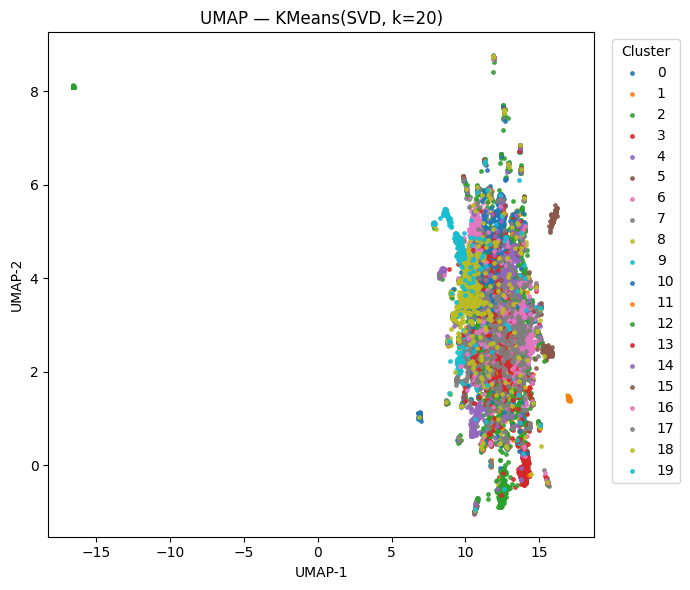

In [9]:
N_NEI, MIN_DIST = 35, 0.05
um = umap.UMAP(n_neighbors=N_NEI, min_dist=MIN_DIST, metric="cosine", random_state=42)
X2 = um.fit_transform(X_svd)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
for c in sorted(df["cluster"].unique()):
    m = df["cluster"].values==c
    plt.scatter(X2[m,0], X2[m,1], s=6, label=str(c), alpha=0.85)
plt.legend(title="Cluster", bbox_to_anchor=(1.02,1), loc="upper left")
plt.title(f"UMAP — KMeans(SVD, k={best_k})"); plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.tight_layout(); plt.show()

**Interpretasi**

Sebaran titik membentuk pilar vertikal sempit dengan warna saling tumpang-tindih hampir di seluruh area; tidak terlihat “pulau” terpisah yang bersih. Ini menandakan pemisahan klaster lemah di ruang representasi saat ini—selaras dengan nilai Silhouette yang sangat kecil. Terlihat beberapa outlier di kiri/atas, tetapi mayoritas titik tetap bertumpuk, menunjukkan tema yang bercampur. Karena sumbu UMAP bersifat non-linear dan tanpa makna fisik, pola tumpang-tindih inilah yang penting: struktur topik ada namun tidak tegas, sehingga k besar cenderung hanya membagi noise.

## 9) (Opsional) Sentence Embeddings

In [ ]:
USE_SENT_EMB = False
if USE_SENT_EMB:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    E = model.encode(df["text"].tolist(), batch_size=256, show_progress_bar=True, normalize_embeddings=True)
    idx = np.random.RandomState(42).choice(len(E), size=min(4000,len(E)), replace=False)
    Es = E[idx]
    rows = []
    for k in range(2, 21):
        km2 = KMeans(n_clusters=k, random_state=42, n_init=10)
        lab = km2.fit_predict(Es)
        sil = silhouette_score(Es, lab, metric="cosine")
        rows.append((k,sil))
    print(sorted(rows, key=lambda x: -x[1])[:10])

## 10) Ekspor artefak

In [ ]:
OUT = Path("/content/uts_text_enhanced")
OUT.mkdir(exist_ok=True)
df_out = df[["id","title","overview","cluster","dist"]]
df_out.to_csv(OUT/"clusters_svd.csv", index=False)
with open(OUT/"top_terms.json","w") as f:
    json.dump({int(c):terms for c,terms in top_terms}, f, indent=2)
print("Saved to:", OUT)